# Python Learn by Doing: ENSO Analysis

Developed By: Dr. Kerrie Geil, Mississippi State University

Date: April 2024

Requirements: list space, RAM, and pacakge requirements

Link: notebook available to download at 

<u> Description </u>

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around the El Nino Southern Oscillation (ENSO) climate pattern and its effects on temperature and precipitation. The notebook is aimed at learners who already have some knowledge of programming and statistics. 

<u> Summary of Contents </u>

put an outline of tasks/skills here

-----

# Introduction to ENSO

Put a description of what they are

Include a bunch of links
different ENSO indices https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni




# Science Questions

To pick up some useful intermediate python programming skills, this notebook will investigate the following ENSO-related science questions using simple statistics:

1) How many seasons (boreal DJF,MAM,JJA,SON) since xxxx have had strong El Nino and La Nina conditions?
2) Using composite analysis, what pattern do we see in sea surface temperature during El Nino and La Nina?
3) In which season(s) does El Nino have the strongest impacts on global temperature and precipitation?
4) Which areas of the United States experience statistically significant ENSO impacts on temperature and precipitation?
5) On average, is it El Nino or La Nina that has stronger effects on temperature and precipitation in the US?

**Disclaimer:** This notebook is intended for python programming learning. There are many datasets and statistical methods we could use to answer our science questions. The techniques used in this notebook are chosen for their simplicity since we are focused on learning intermediate programming skills as opposed to a focus on producing peer-review level analyses. You will undoubtedly see different techniques, thresholds, seasons, and more complex statisical methods used in ENSO literature. 


data description | frequency | units | dataset name | source
---|---|---|---|---
nino 3.4 sst index | monthly | n/a | Nino 3.4 SST index | [NOAA PSL](https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data)
sea surface temperature | monthly | C | HadISST1 | [UKMO Hadley Centre](https://www.metoffice.gov.uk/hadobs/hadisst/)
average air temperature | monthly | C | BEST | [Berkeley Earth](https://berkeleyearth.org/data/)
precipitation | monthly | mm/day | NOAA PREC/L | [NOAA PSL](https://psl.noaa.gov/data/gridded/data.precl.html)


# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import os
# from urllib.request import urlretrieve
import xarray as xr
import numpy as np
import pandas as pd

import numpy.testing as npt
import warnings

import matplotlib.pyplot as plt
from collections import OrderedDict
# import gzip
# import shutil

# import pandas as pd

In [2]:
# learners need to update these paths to reflect locations on their own computer/workspace

# path to your working directory (where this notebook is on your computer)
# work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/ENSO/' 
work_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/' 

# path to where you'll download and store the data files
# data_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/ENSO/'
data_dir=r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/'

# path to write output files and figures
output_dir = work_dir+'outputs/'

# create directories if they don't exist already
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Obtaining the Data

Scripted downloads of the datasets used here can be found in a separate notebook called [get_enso_datasets.ipynb](). If you haven't obtained the data already, use the get_enso_datasets notebook to download the Nino3.4 index, HadISST1 sea surface temperature, Berkeley Earth temperature, and GPCC precipitation data.

# Data Pre-processing

In [3]:
# filenames
nino_f = data_dir+'nino34_anomalies_monthly_NOAA.txt'
sst_f = data_dir+'sst_monthly_HadISST1_UKMO.nc'
t_f = data_dir+'tavg_monthly_BerkeleyEarth.nc'
pr_f = data_dir+'precip_monthly_GPCC_NOAA.nc'

### Nino 3.4 Index

In [4]:
# load nino3.4 index data

# our data file contains a row for each year of data and each column is one of 12 monthly anomaly values for the Nino 3.4 area 
# the base period for the anomalies is 1981-2010

# there are plenty of ways to load txt data, we'll use pandas
nino_raw=pd.read_csv(nino_f,sep='\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino_raw

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07
2022,-0.77,-0.68,-0.84,-0.90,-1.02,-0.77,-0.56,-0.96,-1.06,-0.99,-0.76,-0.86


In [5]:
# collapse the data into a 1D array timeseries
nino=nino_raw.to_numpy().flatten()

len(nino),nino

(1860, array([-1.  , -1.2 , -0.83, ...,   nan,   nan,   nan]))

In [6]:
# create datetimes
dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

len(dates),dates[0:3]

(1860,
 DatetimeIndex(['1870-01-01', '1870-02-01', '1870-03-01'], dtype='datetime64[ns]', freq='MS'))

In [7]:
# create an xarray object with metadata labels attached (time)
nino=xr.DataArray(nino,dims='time',coords={'time':dates})
nino

<xarray.DataArray (time: 1860)>
array([-1.  , -1.2 , -0.83, ...,   nan,   nan,   nan])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2024-12-01

In [8]:
# subset in time

### Sea Surface Temperature

In [9]:
ds=xr.open_dataset(sst_f)
ds

<xarray.Dataset>
Dimensions:    (time: 1850, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    2/4/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [10]:
sst=ds.sst
sst

<xarray.DataArray 'sst' (time: 1850, latitude: 180, longitude: 360)>
[119880000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [11]:
# subset in time

In [12]:
# calculate anomalies

### Precipitation

In [13]:
ds=xr.open_dataset(pr_f)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 915)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-03-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          Precipitation Reconstruction over Land (PREC/L): 1.0x1.0
    platform:       Analyses
    institution:    NOAA ESRL/PSD
    citation:       Chen, M., P. Xie, J. E. Janowiak, and P. A. Arkin, 2002: ...
    history:        created 01/2011 by CAS\nConverted to chunked, deflated Ne...
    Conventions:    CF-1.2
    dataset_title:  Precipitation Reconstruction over Land (PREC/L)
    data_modified:  2019-02-25
    References:     http://www.psl.noaa.gov/data/gridded/data.precl.html

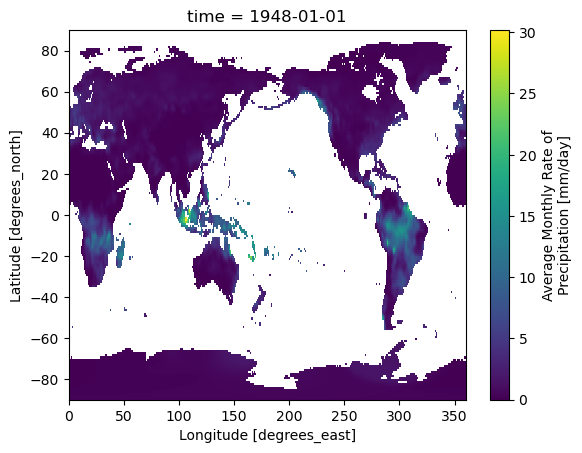

In [14]:
ds.precip.isel(time=0).plot()


### Temperature

In [ ]:
ds=xr.open_dataset(t_f)
ds

In [ ]:
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
len(dates)

In [ ]:
ds['time']=dates
ds=ds.rename({'month_number':'month'})
ds

In [ ]:
# change base period
t_anom_5180=ds.temperature
clim_5180=ds.climatology

In [ ]:
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t

In [ ]:
# new base period climatological values
t_subset=t.sel(time=slice('1981','2010'))
clim_8110 = t_subset.groupby(t_subset.time.dt.month).mean('time')
clim_8110

In [ ]:
# new anomalies
t_anom=t.groupby(t.time.dt.month)-clim_8110

# subset in time
# t_anom=t_anom.sel()

In [ ]:
pr = xr.open_dataarray(filenames[0])
tx = xr.open_dataarray(filenames[1])
tn = xr.open_dataarray(filenames[2])
pr

In [ ]:
pr=pr.squeeze()
tx=tx.squeeze()
tn=tn.squeeze()
pr

# Data Cleaning

### ETCCDI suggested data cleaning / quality control

The minimum quality control procedures suggested by ETCCDI are as follows.

Replace data value with Nan for:
- user-defined missing values (i.e -9999-->Nan)
- daily precip values less than 0
- daily max temperature less than daily minimum temperature
- daily temperature greater than 70C (158F) or less than -70C (-94F)
- leap days (i.e Feb 29th)
- impossible dates (i.e. 32nd March, 12th June 2042)
- non-numeric values
- daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)


Addressing each of these items below...

#### nan for user-defined missing values (i.e -9999-->Nan)

xr.open_dataset does this for you. 


Notice in the variable attributes above there is no _FillValue=-9999., which the value stored for missing data in the netcdf. This is because xarray automatically replaces the _FillValue with nan.

#### nan for daily precip values less than 0

In [ ]:
# are there any negatives?
(pr<0).data.sum()

#### nan for daily max temperature less than daily minimum temperature

In [ ]:
# is tx ever less than tn?
(tx<tn).data.sum()

In [ ]:
# # where tx<tn fill both tx and tn with nan
# tx=xr.where(tx<tn,np.nan,tx)
# tn=xr.where(tx<tn,np.nan,tn)

In [ ]:
# # is tx ever less than tn now?
# (tn>tx).data.sum()

#### nan for daily temperature greater than 70C (158F) or less than -70C (-94F)

In [ ]:
# is tx>70C, tx<-70C, tn>70C, or tn<-70C?
((tx>70)|(tx<-70)).data.sum(), ((tn>70)|(tn<-70)).data.sum()

#### leap days (i.e Feb 29th)

here we'll just drop the leap days from the data arrays rather than filling with nan


In [ ]:
# first let's double check that the time dimension is the same for 
# all of our data arrays
assert list(pr.time.data)==list(tx.time.data), 'pr.time and tx.time are not equal'
assert list(pr.time.data)==list(tn.time.data), 'pr.time and tn.time are not equal'

# another way to do the same thing without having to convert data structure is with numpy.testing
npt.assert_array_equal(pr.time,tx.time,'pr.time and tx.time are not equal')
npt.assert_array_equal(pr.time,tn.time,'pr.time and tn.time are not equal')

In [ ]:
# # find all the leap days
# leapdays=pr.time[(pr.time.dt.day==29) & (pr.time.dt.month==2)]
# leapdays

In [ ]:
# find the indexes to all the leap days
leap_ind=np.where((pr.time.dt.day==29) & (pr.time.dt.month==2))[0]
leap_ind

In [ ]:
# # drop the leap days from the data arrays
# pr=pr.drop_sel(time=leapdays)
# tx=tx.drop_sel(time=leapdays)
# tn=tn.drop_sel(time=leapdays)
# len(pr)

# fill with nan
# pr=pr.where((pr.time.dt.day==29) & (pr.time.dt.month==2),np.nan,pr)
pr[leap_ind]=np.nan
tx[leap_ind]=np.nan
tn[leap_ind]=np.nan
pr[leap_ind]


#### nan for impossible dates (i.e. 32nd March, 12th June 2042)

This data has datetimes for the time dimension. If there were impossible dates, xarray would have had a problem at the open_dataarray statement. So we know there are no impossible dates present.

There could be dates missing, but we can check that just by looking at the length of the time dimension. We have 45 years of daily data, now without leap days. 45years * 365days = 16425days

In [ ]:
pr.shape, tx.shape, tn.shape

#### nan for non-numeric values

Similarly, use of netcdf and xarray ensures that there are no non-numeric values. Each variable in the data file is of one data type (e.g. float) and if there were a non-float value present there would have been an error already. We can be assured the data we've read is all float

In [ ]:
pr.dtype, tx.dtype, tn.dtype

#### daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)

In [ ]:
# find the time-mean for each day of the year
tx_daily_mean=tx.groupby(tx.time.dt.dayofyear).mean('time')
tn_daily_mean=tn.groupby(tn.time.dt.dayofyear).mean('time')
tx_daily_mean

In [ ]:
# find the standard deviation for each day of the yar
# .std throws a runtime warning about degrees of freedom because of 
# nan in the data so we supress the warnings here

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
    tx_stddev=tx.groupby(tx.time.dt.dayofyear).std('time')
    tn_stddev=tn.groupby(tn.time.dt.dayofyear).std('time')
tx_stddev

In [ ]:
# define daily outlier temperature as exceeding the mean +/- 3 times standard deviation
tx_outlier_upper, tx_outlier_lower=(tx_daily_mean+tx_stddev*5), (tx_daily_mean-tx_stddev*5)
tn_outlier_upper, tn_outlier_lower=(tn_daily_mean+tn_stddev*5), (tn_daily_mean-tn_stddev*5)
tx_outlier_upper

In [ ]:
print('tx',(tx.groupby(tx.time.dt.dayofyear)>tx_outlier_upper).data.sum(), (tx.groupby(tx.time.dt.dayofyear)<tx_outlier_lower).data.sum())
print('tn',(tn.groupby(tn.time.dt.dayofyear)>tn_outlier_upper).data.sum(), (tn.groupby(tn.time.dt.dayofyear)<tn_outlier_lower).data.sum())

#### let's also look at how many missing values we have per month

In [ ]:
# a function that sums the number of nans in each month of data
def get_nans_per_month(data_in):
    month_groups=pd.MultiIndex.from_arrays([data_in.time['time.year'].data,data_in.time['time.month'].data])
    data_in.coords['month_groups']=('time',month_groups)    
    nancount=data_in.isnull().groupby('month_groups').sum()
    return nancount

In [ ]:
pr_nan_per_month=get_nans_per_month(pr.copy())
tx_nan_per_month=get_nans_per_month(tx.copy())
tn_nan_per_month=get_nans_per_month(tn.copy())
# pr_nan_per_month

In [ ]:
# create datetimes for the x axis
time_months=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='MS')

# plot
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(311)
plt.plot(time_months,pr_nan_per_month)
plt.title('prcp, number of nans per month')

ax=fig.add_subplot(312)
plt.plot(time_months,tx_nan_per_month)
plt.title('tmax, number of nans per month')

ax=fig.add_subplot(313)
plt.plot(time_months,tn_nan_per_month)
plt.title('tmin, number of nans per month')

plt.tight_layout()
plt.show()

# Calculate climate change indicators

### Monthly Maximum Value of Daily Minimum Temperature (TNx)

- max(each month of daily minimum temperature values)

Here we are inputting daily data and pulling out 1 value per month.

In [ ]:
# this is similar to how we found nans per month

# create an index for every month in the timeseries
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# add the month_groups index as a new coordinate (labels)
# the month_groups coordinate will allow us to groupby months in the next step 
# each day of data in any particular month will be associated with a label in the month_groups coordinate
tn.coords['month_groups']=('time',month_groups)    
tn

In [ ]:
# now groupby month and find the maximum value of each month
# this should return 1 value for every month, 45 years x 12 months = length 540
TNx=tn.groupby('month_groups').max()
TNx

In [ ]:
# using the monthly datetimes that we created earlier (time_months) for the x axis values, plot TNx

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_months,TNx) # plt.plot is from matplotlib.pyplot
plt.title('Monthly Maximum Value of Daily Minimum Temperature (TNx)')
plt.ylabel('degrees C')
plt.show()

### Monthly Maximum Consecutive 5-day Precipitation (Rx5day)

- max(5-day rolling mean precipitation within each month)

Here we are inputting daily data, for each month calculating the mean precipitation amount for each 5-day window of data values, then choosing the maximum of 5-day window value for each month.

In [ ]:
# find all the leap days by label
leapdays=pr.time[(pr.time.dt.day==29) & (pr.time.dt.month==2)]
leapdays

In [ ]:
pr_noleap=pr.drop_sel(time=leapdays)

len(pr_noleap),len(pr)

In [ ]:
# we want to group by each month again
# we'll assign an index as a new coordinate for this 
month_groups_noleap=pd.MultiIndex.from_arrays([pr_noleap.time['time.year'].data,pr_noleap.time['time.month'].data])
pr_noleap.coords['month_groups_noleap']=('time',month_groups_noleap) 
pr_noleap

In [ ]:
# let's take a look at how to use .groupby
# see what happens if we group by month_groups
# there should be 45 years x 12 months = 540 groups of data
# .groupby returns an object that can be iterated over in the form (label,group_array_of_data) pairs
pr_noleap.groupby(pr_noleap.month_groups_noleap)


In [ ]:
# how to access the group labels
pr_noleap.groupby(pr_noleap.month_groups_noleap).groups.keys()

In [ ]:
# how to access the array indexes assigned to a group label
label=(1979,5)
pr_noleap.groupby(pr_noleap.month_groups_noleap).groups[label]

In [ ]:
# how to access the array data assigned to a group label
pr_noleap.groupby(pr_noleap.month_groups_noleap)[label]

In [ ]:
# now we want to find the maximum value of the 5-day rolling mean in each month
# let's test with one month first
window_len = 5  # days

# using rolling to divide the month of data up into 5-day windows
# then take the mean of each 5-day window if all 5 days in the window have finite data values (not nan)
# then find the maximum value of the above
# the result should be a single value
pr_noleap.groupby(pr_noleap.month_groups_noleap)[label].rolling(time=window_len,min_periods=window_len).mean().max()


In [ ]:
# now do the calculation for all months using a for loop
results=[]  # empty list

# loop through each label,data pair in the groupby object
for label,data_group in pr_noleap.groupby(pr_noleap.month_groups_noleap):
    # append the result for each month to our results list
    results.append(data_group.rolling(time=window_len,min_periods=window_len).mean().max())

# the result should be 1 value for every month (45 years x 12 months = length 540)
print(len(results))

# look at the first item in the list
results[0]

In [ ]:
# even though each monthly calculation returns a single value
# that value is returned as an xarray DataArray with some metadata attached
# to get all our results back into a single object we can concatenate the list of xr.DataArrays

Rx5day=xr.concat(results,dim='time') # concat on a new dimension called time
Rx5day

In [ ]:
pr_noleap.time.data[0]

In [ ]:
# make the new time dimension a coordinate (supply time labels)

# first make an array of datetimes
print(pr_noleap.time.data[0],pr_noleap.time.data[-1]) # first and last time in string format

time_months=pd.date_range(pr_noleap.time.data[0],pr_noleap.time.data[-1],freq='MS') # full array of datetimes

print(time_months[0:4])

# assign the time coordinate labels
Rx5day.coords['time']=('time',time_months)    

# while we're at it, assign some variable attributes
# if we use xarray plotting, some of this will show up automagically on the plot
var_atts={'standard_name':'precipitation','units':'mm/day','description':'monthly maximum of monthly 5-day rolling mean prcp'}
Rx5day.attrs=var_atts

Rx5day

In [ ]:
# plot
# use xarray plotting (which is based on matplotlib) by calling .plot on the xr.DataArray object 
fig=plt.figure(figsize=(15,2))
Rx5day.plot() 
plt.title('Monthly Maximum Consecutive 5-day Precipitation (Rx5day)')
plt.show()

### Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)

- annually, the sum of precipitation when precipitation is > 99th percentile of wet day precipitation in the base period 1981-2010
- where a wet day is precipitation >= 1mm

Here we first use daily data during the base period to determine the 99th percentile of wet day precipitation. Then for each year of daily data we determine if each day exceeds the threshold and calculate an annual sum of precip on days that exceed the threshold. 

In [ ]:
# first slice to the base years
pr_baseyrs=pr_noleap.sel(time=slice('1981','2010'))
pr_baseyrs

In [ ]:
# find 99th percentile of wet day precipitation
pr_99w=xr.where(pr_baseyrs>=1.0,pr_baseyrs,np.nan).quantile(0.90)
pr_99w

In [ ]:
# reshape our pr timeseries into a 2D array where rows are the years and columns are the months

# first re-assign the time labels to equal month_groups
pr_noleap_copy=pr_noleap.copy()
pr_noleap_copy=pr_noleap_copy.assign_coords({'time':pr_noleap_copy.month_groups_noleap})

# now unstack the multi-index to create a 2D array 45 x 12
pr_2D=pr_noleap_copy.unstack('time')
pr_2D



In [ ]:
# with the data in 2 dimensions it's easy to do an annual sum of prcp on days over the threshold 
R99pTOT=xr.where(pr_2D>pr_99w,pr_2D,np.nan).sum('time_level_1')
R99pTOT

In [ ]:
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(R99pTOT.time_level_0,R99pTOT)
plt.title('Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)')
plt.ylabel('mm/year')
plt.show()

### Maximum Length of Consecutive Dry Days (CDD)

- annually, the maximum length of consecutive days where precipitation is < 1mm
- not looking at dry spells that span over multiple years, just cutting off the search at the end of each year

Here we are inputting daily data, determining whether each day falls under the precipitation threshold, and finding the longest period of consecutive days each year that meets the threshold requirement. 

In [ ]:
# we'll use pr_noleap again 
pr_noleap

In [ ]:
# make a mask where 1=dry and 0=wet
threshold = 1  # mm/day
data_mask = xr.where(pr_noleap<threshold,1,0)
data_mask

In [ ]:
# group the data by year
data_mask_grouped=data_mask.groupby(data_mask.time.dt.year)
data_mask_grouped

In [ ]:
# use nested for loops to find the longest stretch of dry days in each year

CDD=[] # empty list to store results

# loop through each year
for year,data1yr in data_mask_grouped:
    
    counter=0
    longest_counter=0

    # loop through each day
    for iday in range(len(data1yr)):

        # if it's a dry day, increment the counter
        if data1yr[iday]==1: counter+=1

        # keep track of the longest consecutive amount of dry days
        if counter>longest_counter: longest_counter=counter

        # if it's not a dry day (0 or nan), start the counter over at 0
        if data1yr[iday]!=1: counter=0

    # add to the dictionary
    CDD.append(longest_counter)
    longest_counter=0
    counter=0

# look at the results for first 5 years
CDD[0:5]

In [ ]:
# using annual datetimes that we've already created for x axis values
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,CDD)
plt.title('Maximum Length of Consecutive Dry Days (CDD)')
plt.ylabel('days')
plt.show()

### Growing Season Length (GSL)

- annually, growing season starts on the first day of the first six consecutive day period where daily mean temperature is > 5C
- annually, growing season ends on the first day after 1 July of the first six consecutive day period where daily mean temperature is < 5C

Here we are inputting daily data, pulling out 2 dates per year, and calculating the number of days between the two dates.


In [ ]:
threshold = 5   # degrees C
window_len = 6  # consectutive days

# calculate mean temperature
t_mean=(tn+tx)/2

In [ ]:
# to find the start and end of the growing season
# we will need to "roll" through time.
# in order for the leap days (that we filled with nan)
# to not mess us up, we'll need to drop those days from the data

# leapdays=t_mean.time[(t_mean.time.dt.day==29) & (t_mean.time.dt.month==2)]
t_mean_noleap=t_mean.drop_sel(time=leapdays)
len(leapdays),len(t_mean_noleap),len(t_mean)

In [ ]:
# we'll want to group by years to find the start and end of the growing season for each year
# in this case we don't need to assign a new coordinate to use groupby
# we can use .dt on xr.DataArrays of datetimes to select/subset/group (xarray .dt operates the same as pandas .dt)
t_mean_noleap.groupby(t_mean_noleap.time.dt.year)

In [ ]:
# how to access the group labels
# t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups.keys()

In [ ]:
# how to access the array indexes assigned to a group label
# testyear=1979
# t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups[testyear]

In [ ]:
# how to access the array data assigned to a group label
# data_1yr=t_mean_noleap[t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups[testyear]]
year=1979
data_1yr=t_mean_noleap.groupby(t_mean_noleap.time.dt.year)[year]
data_1yr

In [ ]:
# make a mask for where daily temperature is greater than 5C
data_mask=xr.where(data_1yr>threshold,1,0)
data_mask

In [ ]:
# separate the timeseries into windows of length 6
# the first window has the first value of the data_mask (index 0) in the last position of the window 
# plus the 5 preceeding values of the data_mask, which in this case are nan because we're at the beginning of the data_mask array
# the 6th window (index 5) should be equal to the first 6 values of data_mask (no nans)

# create the windows
windows=data_mask.rolling(time=window_len,center=False).construct('window')

# print the window with the first 6 values of data_mask
print(windows.isel(time=window_len-1))

# print array info
windows


In [ ]:
# find the sum of each window
# this will tell us how many days per window are over the 5C threshold
# ignore windows that contain any nans
windows.sum('window',min_count=window_len)

In [ ]:
# find the indexes of each 6-day window where all days were over the 5C threshold
# np.where returns a tuple in this case where the resulting array is 
# in the first index of the tuple. this is why we use the [0] to pull the array from the tuple
np.where(windows.sum('window')==window_len)[0]


In [ ]:
# now take the first value of the result above
# this is the first window where the requirement was met (6 days above 5C)
# the windows are indexed as their last day, i.e. the 5th index window contains index days 0,1,2,3,4,5 
# the start of the growing season is the first day of the first 6-day period meeting the 5C requirement
# so to get the index of the first day in the window we subtract 5
gs_start_ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
gs_start_ind

In [ ]:
# now let's search for the end of the growing season
# we know to only look after July 1, what index is that?
label=str(year)+'-07-01'
minval=t_mean_noleap.indexes['time'].get_loc(label)
minval

In [ ]:
# now do similar steps to find the end of the growing season

# 0/1 mask for where temperature is less than 5C
data_mask=xr.where(data_1yr<threshold,1,0)
data_mask

In [ ]:
# split up into 6-day windows
windows=data_mask.rolling(time=window_len,center=False).construct('window')
windows

In [ ]:
# get the index to all the windows where temperature is always less than 5C
np.where(windows.sum('window')==window_len)[0]

In [ ]:
# get the index to all the windows where temperature is lt 5C
# but remember the index is to the last date in the window and we want the index of the first date
# so we subtract 5 and save the result as an array
possible_inds=np.where(windows.sum('window')==window_len)[0] - (window_len-1)
possible_inds

In [ ]:
# subset possible_inds to only indexes that correspond to days after July 1
# and take the first value in that result
gs_end_ind=possible_inds[possible_inds>minval][0]
gs_end_ind

In [ ]:
# functions to do what we did above for each year
# we'll put these functions in a loop below

def get_gs_start(data_1yr):
    mask=xr.where(data_1yr>threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
    return ind

def get_gs_end(data_1yr):
    mask=xr.where(data_1yr<threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    # sometimes it may be warm through the end of the year
    # in these cases we would end up with an error if no windows meet the <5C requirement
    # try/except works to pass in the last day of the year as the end of the growing season in these cases
    try:
        possible_inds=np.where(windows.sum('window')==window_len)[0]
        ind=possible_inds[possible_inds>minval][0]
    except:
        ind=364 # index of the last day of year
    return ind

In [ ]:
# group the data by year and loop through each year's worth of data
# to find the index of the start and end of the growing season 

# create empty lists for storing results
gs_start_list=[]
gs_end_list=[]

# loop through years of data
# .groupby returns an object that can be iterated over in the form (label,group_array_of_data) pairs
# here "label" are the years
# and "group" are a year's worth of data values
for label,group in t_mean_noleap.groupby(t_mean_noleap.time.dt.year):
    # call our functions and append the result to our lists
    gs_start_list.append(get_gs_start(group))
    gs_end_list.append(get_gs_end(group))

# look at the first 5 values of each list
gs_start_list[0:5], gs_end_list[0:5]

In [ ]:
# double check our work
assert all(x>=0 for x in gs_start_list), "negative values in gs_start_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_start_list"
assert all(x>=minval for x in gs_end_list), f"values<{minval} in gs_end_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_end_list"

In [ ]:
# calculate the growing season length for each year
# this is called a "list comprehension"
# it executes a for loop and returns results inside a list
GSL = [end_ind-start_ind for end_ind,start_ind in zip(gs_end_list,gs_start_list)] 

# # below is identical to above
# GSL=[]
# for end_ind,start_ind in zip(gs_end_list,gs_start_list):
#     GSL.append(end_ind-start_ind)

# check out the first 5 values
GSL[0:5]

In [ ]:
# annual datetimes for x axis values
time_annual=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='YS')

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,GSL)
plt.title('Growing Season Length (GSL)')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_start_list)
plt.title('Start of Growing Season DOY')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_end_list)
plt.title('End of Growing Season DOY')

### Warm Spell Duration Index (WSDI)

- 6 consecutive days of hot maximum temperatures
- hot temperature threshold defined as > 90th percentile of maximum temperature for each calendar day using a centered 5-day window in the base period 1981-2010
- warm spells that contain dates for multiple years are assigned to the year when the spell ends

Here we first use daily data during the base period to determine the daily 90th percentile temperature threshold. Then using all years of daily data we decide whether each calendar day exceeds the hot threshold, then find occurrences where the threshold is exceeded for at least 6 consecutive days (this is a warm spell), then sum the number of days annually in the warm spells.

Notice that this is not the same as finding dangerous heat waves with respect to human health because it is based on a temperature threshold for each calendar day. This means that the WSDI will include winter warm spells where the temperature exceeds the 90th percentile of winter daily temperature, which would likely be a comfortable temperature.

In [ ]:
# first let's find the 90th percentile temperature for each calendar day (using a centered 5 day window)
# this means that to determine the 90th percentile temperature for a given day we need 
# that day's temperature in each year as well as the temperature for 2 days before and 2 days after in each year
# we'll set it up to find the answer for 1 day first and then make a loop to compute all other days

# starting with Feb 1



n_baseyrs=30
# base_first='1981'
# base_last='2010'

day_first=1
day_last=365
doy=list(np.arange(day_first,day_last+1))*n_baseyrs
doy= [364,365] + doy + [1,2]

len(doy), doy[0:9]


In [ ]:
tx_noleap_baseyrs=tx.drop_sel(time=leapdays).sel(time=slice('1980-12-30','2011-01-02'))
tx_noleap_baseyrs

In [ ]:
tx_noleap_baseyrs.coords['doy_noleap']=('time',doy)
tx_noleap_baseyrs

In [ ]:
tx_windows=tx_noleap_baseyrs.rolling(time=5,center=True).construct('window')
tx_windows


In [ ]:
# drop the windows centered on the extra dates
tx_windows=tx_windows.drop_sel(time=['1980-12-30','1980-12-31','2011-01-1','2011-01-02'])
tx_windows

In [ ]:
# now groupby our doy index 'doy_noleap'
# each group will contain the temperature for a single doy of every year plus the two days before and two days after
# in other words, each group is the 5-day centered window for a given doy for all years 
# 5 days * 30 years = 150 data values in each group
tx_grouped=tx_windows.groupby(tx_windows.doy_noleap)

# let's look at what is in a data group for doy 15
tx_grouped[15]

In [ ]:
# now find the 90th percentile of data values in each group
# we should end up with 1 value for each doy of the year (excluding leap days)
threshold90=tx_grouped.quantile(0.9,dim=['time','window'])
threshold90

In [ ]:
# prep tx for comparison to threshold90
# this time use all data (don't subset in time)
nyears=45
doy=list(np.arange(day_first,day_last+1))*nyears
tx_noleap=tx.drop_sel(time=leapdays)
tx_noleap.coords['doy_noleap']=('time',doy)
tx_noleap


In [ ]:
# determine which days exceed threshold90
# these are the hot days
tx_hot_mask = tx_noleap.groupby(tx_noleap.doy_noleap) > threshold90
tx_hot_mask

In [ ]:
# how many True days and how many False?
ntrue=tx_hot_mask.sum()
nfalse=len(tx_hot_mask)-ntrue
ntrue,nfalse

In [ ]:
tx_hot_mask.time.isel(time=6).data + np.timedelta64(1,'D')#.data#,tx_hot_mask.time.isel(time=6).data.timedelta(days=1)
# tx_hot_mask.time.isel(time=6).dt.strftime("%a, %b %d %H:%M").data
# tx_hot_mask.time.isel(time=6).dt.strftime("%Y-%m-%d").timedelta(days=1)
window_len

In [ ]:
i=6
np.arange(i-(window_len-1),i+1)

# tx_hot_mask.isel(time=6)
date=tx_hot_mask.time.isel(time=i).data
print(date)
dates=pd.date_range(date-np.timedelta64(window_len-1,'D'),date-np.timedelta64(0,'D'))
dates

In [ ]:
# we'll loop in time to identify warm spells in each year and sum the days in warm
count=0
hot_inds=[]
hot_dates=[]
# event_year=[]

for i,value in enumerate(tx_hot_mask):
    if value: count=count+1 # if True start a counter
    else: count=0

    if count>=window_len:
        inds=np.arange(i-(window_len-1),i+1)
        hot_inds.extend(inds)

        # date=tx_hot_mask.time.isel(time=i).data
        # dates=pd.date_range(date-np.timedelta64(window_len-1,'D'),date-np.timedelta64(0,'D'))
        # hot_dates.extend(dates)
     

    # if i < window_len-1:
len(hot_dates)

In [ ]:
hot_inds=np.unique(hot_inds)
len(hot_inds)

In [ ]:
hot_dates=np.unique(hot_dates)
len(hot_dates)

In [ ]:
# now we need to know which year each warm spell event takes place in
# warm spell days are counted for the year when the spell ends
# are there any warm spells that span over two years?
ind1=None
event_inds=[]
for i,value in enumerate(hot_inds[:-1]):
    if ind1==None:
        ind1=value

    if hot_inds[i+1]==value+1:
        pass
    else:
        ind2=value
        event_inds.append((ind1,ind2)) # append a tuple
        ind1=hot_inds[i+1]

print(len(event_inds))
event_inds

In [ ]:
tx_hot_mask.isel(time=slice(544,566))

In [ ]:
tx_hot_mask.time.isel(time=event_inds[0][0]).dt.year.data


In [ ]:
# do owe have any warm spells that span over multiple years
spell_year=[]
count=0
for startstop in event_inds:
    year_start=tx_hot_mask.time.isel(time=startstop[0]).dt.year.data
    year_end = tx_hot_mask.time.isel(time=startstop[1]).dt.year.data
    if year_start==year_end:
        spell_year.append(year_start)
    else:
        spell_year.append(year_end)
        count+=1
print(count)
spell_year

In [ ]:
# count days in warm spells per year
WSDI=[]
for data_year in np.arange(1979,2023+1):
    day_count=0
    for i,event_year in enumerate(spell_year):
        if event_year==data_year:
            ndays=event_inds[i][1]-event_inds[i][0]+1
        else:
            ndays=0    
        day_count=day_count+ndays
    WSDI.append(day_count)
len(WSDI)

In [ ]:
# using annual datetimes that we've already created for x axis values
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,WSDI)
plt.title('Warm Spell Duration Index (WSDI)')

# Plotting linear trends

In [ ]:
# first we need to clean up our variable's coordinate labels
# this is because the polyfit function we will use doesn't like coordinates like our multi-index "month_groups"

TNx

In [ ]:
TNx=TNx.drop_vars(['month_groups', 'time_level_0', 'time_level_1']) # delete the junk
TNx=TNx.rename({'month_groups':'time'})  # rename the dimension
TNx=TNx.assign_coords({'time':time_months})  # assign new coordinate labels to time dim

# nice and clean
TNx

In [ ]:
# generate least squares linear regression coefficients
coefs=TNx.polyfit(dim='time',deg=2)

# generate the x,y points of the linear regression line
regline=xr.polyval(TNx.time,coefs)

# see our handywork
regline

In [ ]:
# plot the linear regression over the timeseries TNx
fig=plt.figure(figsize=(15,2))
plt.plot(time_months,TNx) # plt.plot is from matplotlib.pyplot
regline.polyfit_coefficients.plot(linestyle='--')
plt.title('Monthly Warmest Night (TNx) with linear trend')
plt.ylabel('degrees C')
plt.show()

let's plot the seasonal mean TNx with the linear trend for each

In [ ]:
TNx_seasonal=TNx.resample(time='QS-DEC').mean()
TNx_seasonal

In [ ]:
TNx_DJF=TNx_seasonal[0::4][1:-1]
TNx_MAM=TNx_seasonal[1::4]
TNx_JJA=TNx_seasonal[2::4]
TNx_SON=TNx_seasonal[3::4]

coefs=TNx_DJF.polyfit(dim='time',deg=2)
reg_DJF=xr.polyval(TNx_DJF.time,coefs)

coefs=TNx_MAM.polyfit(dim='time',deg=2)
reg_MAM=xr.polyval(TNx_MAM.time,coefs)

coefs=TNx_JJA.polyfit(dim='time',deg=2)
reg_JJA=xr.polyval(TNx_JJA.time,coefs)

coefs=TNx_SON.polyfit(dim='time',deg=2)
reg_SON=xr.polyval(TNx_SON.time,coefs)

In [ ]:
# plot the linear regression over the timeseries TNx
fig=plt.figure(figsize=(15,6))
fig.add_subplot(411)
plt.plot(TNx_DJF.time,TNx_DJF)
plt.ylim(TNx_seasonal.min(),TNx_seasonal.max())
reg_DJF.polyfit_coefficients.plot(linestyle='--')
plt.title('Winter Mean Warmest Night')
plt.ylabel('degrees C')

fig.add_subplot(412)
plt.plot(TNx_MAM.time,TNx_MAM)
plt.ylim(TNx_seasonal.min(),TNx_seasonal.max())
reg_MAM.polyfit_coefficients.plot(linestyle='--')
plt.title('Spring Mean Warmest Night')
plt.ylabel('degrees C')

fig.add_subplot(413)
plt.plot(TNx_JJA.time,TNx_JJA)
plt.ylim(TNx_seasonal.min(),TNx_seasonal.max())
reg_JJA.polyfit_coefficients.plot(linestyle='--')
plt.title('Summer Mean Warmest Night')
plt.ylabel('degrees C')

fig.add_subplot(414)
plt.plot(TNx_SON.time,TNx_SON)
plt.ylim(TNx_seasonal.min(),TNx_seasonal.max())
reg_SON.polyfit_coefficients.plot(linestyle='--')
plt.title('Fall Mean Warmest Night')
plt.ylabel('degrees C')

plt.tight_layout()
plt.show()

### Are the Changes In Value of These Indices Over Time Statistically Significant?

In [ ]:
# test if trend is statistically different from zero

### Computing Climate Change Indices on Gridded Data

In [ ]:
# download/unzip data

In [ ]:
# repeat one of the above analysis

In [ ]:
# visualize

# Your Turn!

### Choose one of three coding mini-projects below to complete on your own and prepare to share your findings


**Option 1 (easiest):** Calculate the monthly mean daily temperature range (DTR) and create a figure showing the DTR timeseries. 

&emsp;Hints:
- Use daily tmax and tmin data
- Calculate the daily temperature range as tmax-tmin
- For each month, find the mean of the range values you calculated in the previous step
- Plot your timeseries of monthly values. Include axis labels and a title. 

<br>
<br>

**Option 2 (moderate):** Calculate the cold spell duration index (CDSI) at the xx station and create a figure showing the CDSI timeseries. Extra: see if you can determine whether the change in the CDSI is statistically significant.

&emsp;Hints:
- Use daily tmin data
- Find the daily 10th percentile temperature using a centered 5-day window over the base period 1961-1990
- Using all data years, determine if each day exceeds the threshold (looking for days with tmin < threshold)
- Identify cold spells as periods of 6 consecutive days when the temperature exceeds the threshold
- Count how many total cold spell days there are annually (remember each cold spell is assigned to the year when the spell ends)
- Plot the timeseries of annual values. Include axis labels and a title.
- Extra Step: Determine statistical significance of the trend line (linear regression) or the difference in means between two 30-year periods (1941-1970) and (1991-2020).

<br>
<br>


**Option 3 (hardest):** Use a gridded dataset to compute the annual growing season length (GSL) at each grid cell. Then, calculate the trend in GSL at each grid cell and also determine whether each trend is statisically significant. Present your results in a figure that shows the GSL trend for each grid cell (on a map) and include an indication of whether each grid cell value is statistically significant.

&emsp;Hints:
- Use gridded daily tmax and tmin data
- Calculate daily mean temperature
- Use the same process we showed previously to determine the annual start/end of the growing season and find the annual GSL, except this time do the calculations at each grid cell.
- Calculate the trend (linear regression) in annual GSL at each grid cell.
- Determine if each trend is statistically significant.
- Plot the the map of trend values and indicate significance at each grid with hatching or some other visual indicator. Include a title and legend.


# might need to replace one of the above with
 Option: reproduce any of the indices in this notebook using gridded data for Mississippi

 Option: use dask to speed up computation on gridded data



In [ ]:
# peek at the answer figure for option 1

In [ ]:
# peek at the answer figure for option 2

In [ ]:
# peek at the answer figure for option 3

Don't forget to create answer codes for these and put them in the repo. Direct learners to answers after the work-on-your-own session.